In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
full=pd.read_csv("full.csv", index_col=0)
full_w_outs=pd.read_csv("full_w_outs.csv", index_col=0)

In [3]:
full_w_outs['pAvgH']

0      0.131817
1      0.213973
2      0.118798
3      0.062189
4      0.220110
         ...   
755    0.317451
756    0.692428
757    0.426178
758    0.495159
759    0.350195
Name: pAvgH, Length: 760, dtype: float64

In [4]:

cols_base=['opponent', 'team', 'date', 'time', 'round', 'day', 'venue', 'result', 'gf', 'ga','venue_code','pAvgH']

cols_diffs=['goalie_diff', 'defs_diff', 'mids_diff', 'atks_diff', 'offdeff_diff',
       'intensity_diff', 'dirspeed_diff', 'deads_diff', 'press_diff',
       'contra_diff', 'buildup_diff', 'progress_diff', 'carr_diff',
       'wings_diff', 'agresive_diff', 'deferror_diff', 'offsucc_diff']


cols_sel=cols_diffs + ['venue_code',
                     #   'points_rolling'
                       ]
# 7324 7368
# cols_sel.remove('offsucc_diff')
# # 736
# cols_sel.remove('progress_diff')
# cols_sel.remove('atks_diff')
# cols_sel.remove('mids_diff')
# 723 741


# predictors = ["venue_code", "opp_code", "hour", "day_code"]

X_base=full_w_outs[cols_sel]
feature_names=list(X_base.columns)

In [5]:
from sklearn.model_selection import train_test_split
X=X_base
y=full_w_outs['pAvgH'].values
# Reshape y if only one col
# y_train_1d= np.ravel(y_train) 
y = y.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
splited = X_train, X_test, y_train, y_test

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


def make_predictions_reg(data,reg,feature_names,scale=False,grid_params=None,plot_imp=False):
    X_train, X_test, y_train, y_test = data

    if scale:
        # Setup the pipeline steps: steps
        scaler = StandardScaler()
        model = make_pipeline(scaler,reg)
        print(model.steps)
    else:
        model = reg

    if grid_params:
        # Instantiate the GridSearchCV object: cv
        model = GridSearchCV(model, grid_params)

    # Fit the model
    model.fit(X_train, y_train)
    
    # error = accuracy_score(y_test, y_pred)

    try:
        score = model.best_score_
        model = model.best_estimator_
    except:
        pass

    try:
        hparams = model.best_params_
    except:
        hparams = None

    # Predict on the test data: y_pred
    y_pred = model.predict(X_test)

    # Compute and print the coefficients
    try:
        reg_step=model.steps[-1][1].coef_
        if reg_step.shape[0]>1:
            coefs=reg_step
        else:
            coefs=reg_step[0]
    except:
        try:
            coefs=model.coef_[0]
        except:
            pass
    try:
        print(coefs)

        # Plot the coefficients
        plt.plot(range(len(feature_names)), coefs)
        plt.xticks(range(len(feature_names)), feature_names, rotation=60)
        plt.margins(0.02)
        plt.show()
    except:
        coefs=None
    try:
        imps=model.feature_importances_
    except:
        imps=None


    # Compute 5-fold cross-validation scores: cv_scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)

    # Print the 5-fold cross-validation scores
    print(cv_scores)
    print(np.mean(cv_scores))

    # Compute and print R^2 on holdout
    print('R^2 on holdout'),
    score=model.score(X_test, y_test)
    print(score)

    # Evaluate the test set RMSE
    rmse_test = MSE(y_test, y_pred)**(1/2)
    # Print rmse_test
    print('Test set RMSE: {:.3f}'.format(rmse_test))

    # plot_importances
    if plot_imp:
        plot_importances(feature_names,imps,coefs)

    return model,(feature_names),(score)

def plot_importances(feature_names,imps,coefs):
    if imps is not None:
        data=imps
    else:
        data=coefs
    
    # Create a pd.Series of features importances
    importances = pd.Series(data=data, index=feature_names)

    # Sort importances
    importances_sorted = importances.sort_values()

    # Draw a horizontal barplot of importances_sorted
    importances_sorted.plot(kind='barh', color='lightgreen')
    plt.title('Features Importances')
    plt.show()

    return importances_sorted
    

def export_model(clf,filename):
    from joblib import dump
    dump(clf, f'{filename}.joblib') 
    # import pickle
    # s = pickle.dumps(clf)
    # clf2 = pickle.loads(s)

def load_model(clf,fpath):
    from joblib import  load
    clf = load(fpath)

def append_preds(base_df,df_w_features,feature_names,model):
    
    # rest=[x for x in df.columns if not x in feature_names]
    fin=base_df.copy()
    pred=model.predict(df_w_features[feature_names])    
    fin['y_pred']=pred

    return fin

[-0.08009249 -0.05012283 -0.27861145  0.1050623   0.32692575  0.13535118
  0.16967553 -0.38940122  0.04411596  0.27051165 -0.11710067 -0.08373256
 -0.05671531  0.20421981  0.11789338 -0.22555735 -0.06010375  0.11867979]


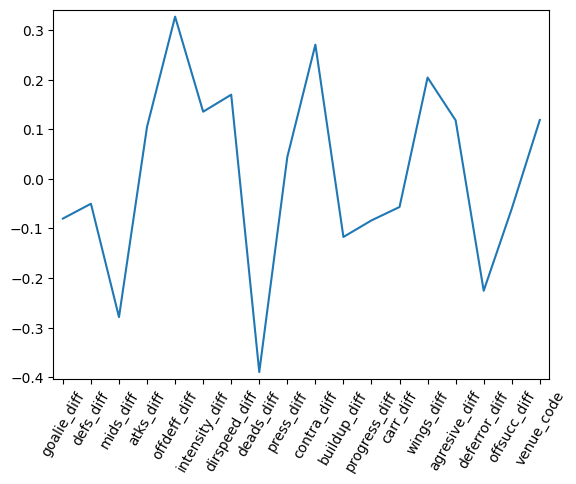

[0.79240499 0.85987051 0.84809406 0.79927629 0.83008768]
0.825946705841786
R^2 on holdout
0.8080703697487417
Test set RMSE: 0.089


In [8]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

model,pred,info=make_predictions_reg(splited,reg,feature_names,scale=False,grid_params=None)

[-0.08009249 -0.05012283 -0.27861145  0.1050623   0.32692575  0.13535118
  0.16967553 -0.38940122  0.04411596  0.27051165 -0.11710067 -0.08373256
 -0.05671531  0.20421981  0.11789338 -0.22555735 -0.06010375  0.11867979]


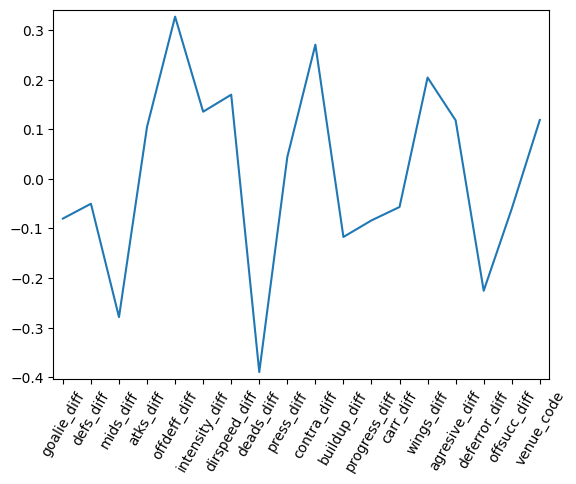

[0.79240499 0.85987051 0.84809406 0.79927629 0.83008768]
0.825946705841786
R^2 on holdout
0.8080703697487417
Test set RMSE: 0.089


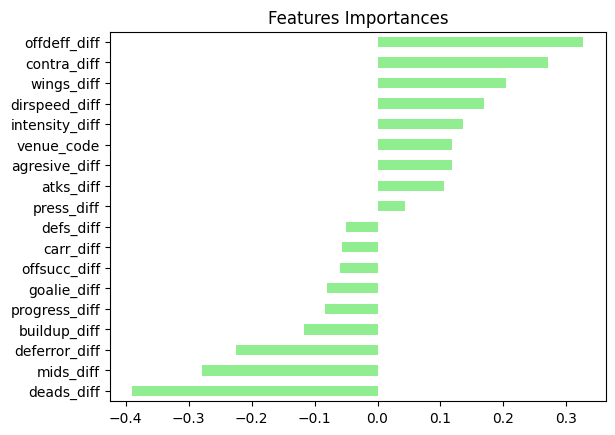

In [25]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
parameters = {'fit_intercept':[True,False],  'copy_X':[True, False]}

model,pred,info=make_predictions_reg(splited,reg,feature_names,scale=False,grid_params=parameters,plot_imp=True)

[('standardscaler', StandardScaler()), ('lasso', Lasso(alpha=0.02))]
[ 0.          0.05060723  0.          0.          0.06666897  0.
 -0.         -0.00350897  0.          0.02496731  0.          0.
 -0.         -0.          0.00068522 -0.02948272  0.          0.03979296]


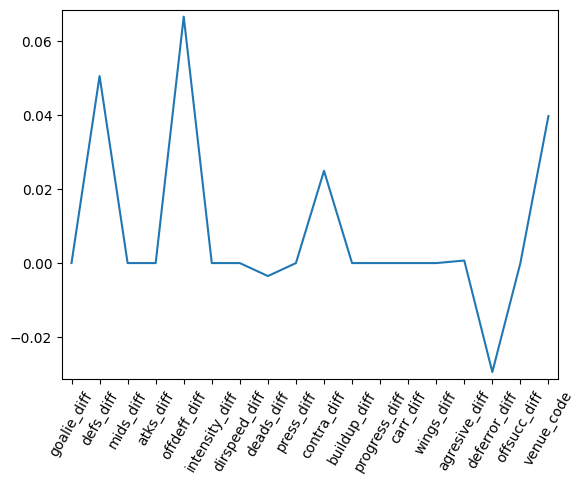

[0.69474012 0.77065089 0.73924456 0.66905853 0.73409789]
0.7215583986336608
R^2 on holdout
0.7134214974318264
Test set RMSE: 0.108


In [27]:
from sklearn.linear_model import Lasso
reg = Lasso(alpha=0.02)

model,pred,info=make_predictions_reg(splited,reg,feature_names,scale=True,grid_params=None)

[('standardscaler', StandardScaler()), ('ridge', Ridge(alpha=0.8))]
[-0.03024006 -0.01468348 -0.10587229  0.03311826  0.14110862  0.05696579
  0.06008127 -0.14637519  0.01871712  0.09961897 -0.047985   -0.03494755
 -0.02320292  0.07391292  0.04867852 -0.09302626 -0.02477615  0.05917616]


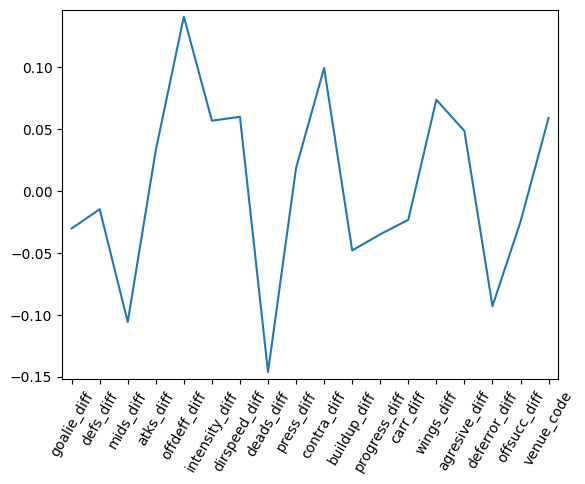

[0.79347904 0.86054771 0.84716731 0.79891708 0.82895524]
0.825813276227502
R^2 on holdout
0.8079892923687575
Test set RMSE: 0.089


In [33]:
from sklearn.linear_model import Ridge
reg = Ridge(alpha=0.8)

model,pred,info=make_predictions_reg(splited,reg,feature_names,scale=True,grid_params=None)

[('standardscaler', StandardScaler()), ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.6))]
[ 0.00747956  0.04182536 -0.          0.          0.07642394  0.
 -0.         -0.00501328  0.          0.0371909  -0.         -0.
 -0.         -0.          0.01837359 -0.04052407 -0.          0.05284267]
(18,)


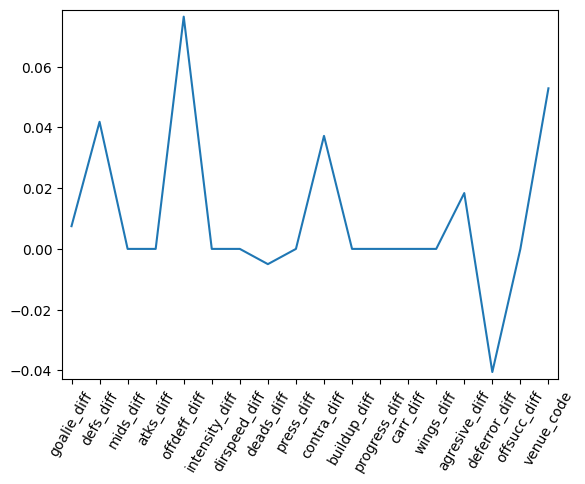

[0.74661355 0.82073386 0.77465477 0.72265306 0.76663164]
0.7662573758534791
R^2 on holdout
0.7615090308423397
Test set RMSE: 0.099


In [69]:
from sklearn.linear_model import ElasticNet
reg = ElasticNet(l1_ratio=0.6, alpha=0.01)

model,pred,info=make_predictions_reg(splited,reg,feature_names,scale=True,grid_params=None)

[0.30007722 0.35482338 0.30134742 0.07598563 0.23272196]
0.25299112143089914
R^2 on holdout
0.3606043934548224
Test set RMSE: 0.162


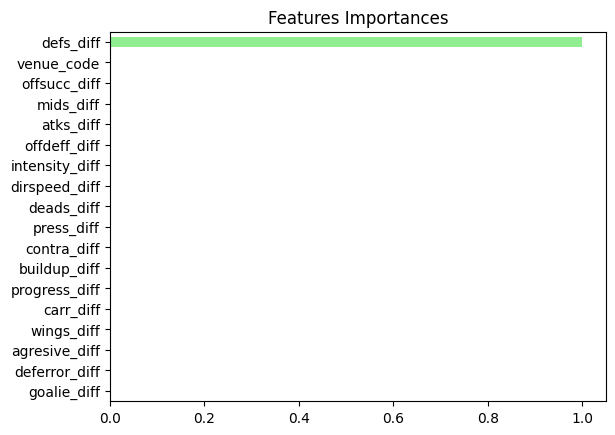

In [87]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.3, random_state=3)

model,pred,info=make_predictions_reg(splited,reg,feature_names,scale=False,grid_params=None,plot_imp=True)


c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\s

[0.71293437 0.78446513 0.67817462 0.68865879 0.66700066]
0.706246711184624
R^2 on holdout
0.7038203012451645
Test set RMSE: 0.110


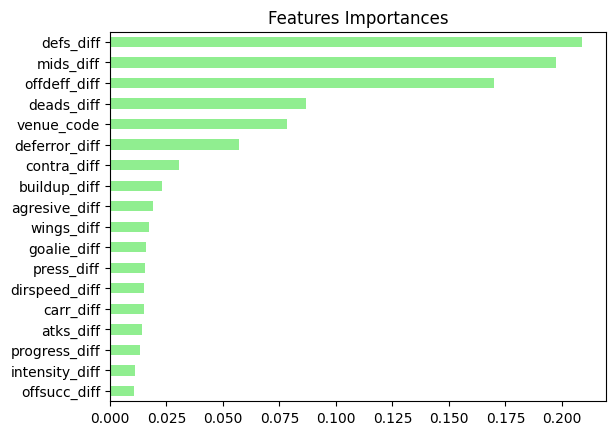

In [88]:
# Random Forests
from sklearn.ensemble import RandomForestRegressor
# Instantiate rf
reg = RandomForestRegressor(n_estimators=25, random_state=2)

model,pred,info=make_predictions_reg(splited,reg,feature_names,scale=False,grid_params=None,plot_imp=True)


c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\ensemble\_gb.p

[0.71275327 0.80437748 0.74872441 0.77045496 0.72286598]
0.7518352213982122
R^2 on holdout
0.7829426363476575
Test set RMSE: 0.094


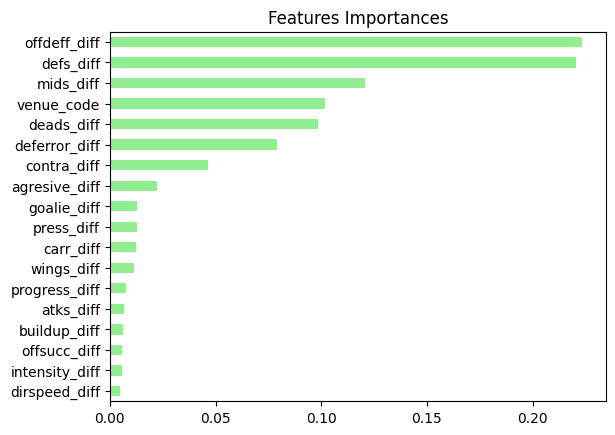

In [89]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
# Instantiate gb
reg = GradientBoostingRegressor(max_depth=3,n_estimators=200,random_state=2)

model,pred,info=make_predictions_reg(splited,reg,feature_names,scale=False,grid_params=None,plot_imp=True)


c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\ensemble\_gb.p

[0.72141911 0.80952068 0.76146852 0.77957    0.71488734]
0.7573731292450875
R^2 on holdout
0.7992514033017495
Test set RMSE: 0.091


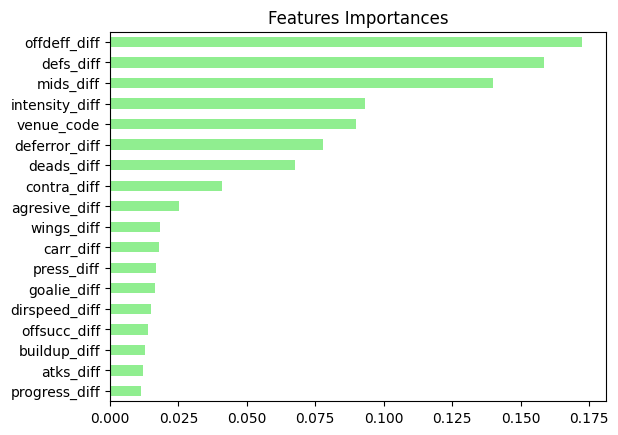

In [90]:
#Stochastic Gradient Boosting (SGB)
from sklearn.ensemble import GradientBoostingRegressor
# Instantiate sgbr
reg = GradientBoostingRegressor(max_depth=4, 
                                 subsample=0.8,
                                 max_features=0.4,
                                 n_estimators=200,                                
                                 random_state=2)

model,pred,info=make_predictions_reg(splited,reg,feature_names,scale=False,grid_params=None,plot_imp=True)


In [12]:
# export_model(clf,'modelname')

fin=append_preds(full_w_outs[cols_base],full_w_outs,feature_names,model)
fin
# fin.to_csv('match_w_pred_2223diff_trsh4s.csv')

,opponent,team,date,time,round,day,venue,result,gf,ga,venue_code,pAvgH,y_pred
0,Arsenal,Aston Villa,2022-08-31,19:30:00,Matchweek 5,Wed,Away,L,1,2,0,0.131817,0.171203
1,Arsenal,Aston Villa,2023-02-18,12:30:00,Matchweek 24,Sat,Home,L,2,4,1,0.213973,0.289883
2,Arsenal,Bournemouth,2022-08-20,17:30:00,Matchweek 3,Sat,Home,L,0,3,1,0.118798,0.071115
3,Arsenal,Bournemouth,2023-03-04,15:00:00,Matchweek 26,Sat,Away,L,2,3,0,0.062189,-0.047565
4,Arsenal,Brentford,2022-09-18,12:00:00,Matchweek 8,Sun,Home,L,0,3,1,0.220110,0.188258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,Wolves,Southampton,2023-02-11,15:00:00,Matchweek 23,Sat,Home,L,1,2,1,0.317451,0.431318
756,Wolves,Tottenham,2022-08-20,12:30:00,Matchweek 3,Sat,Home,W,1,0,1,0.692428,0.624414
757,Wolves,Tottenham,2023-03-04,15:00:00,Matchweek 26,Sat,Away,L,0,1,0,0.426178,0.505734
758,Wolves,West Ham,2022-10-01,17:30:00,Matchweek 9,Sat,Home,W,2,0,1,0.495159,0.531886


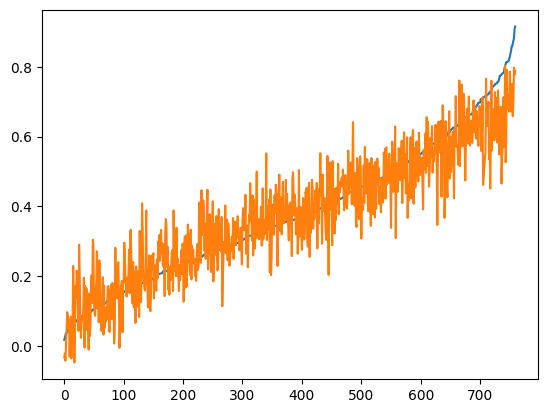

In [46]:
compare=fin.iloc[:,-2:].sort_values(fin.columns[-2])
y=compare.iloc[:,0]
y2=compare.iloc[:,1]
x=range(len(y))
plt.plot(x, y)
plt.plot(x, y2)